# Exploration 16
## 프로젝트 - Movielens 영화 SBR
___

## 목차
- Step 1. 데이터 전처리
- Step 2. 미니 배치 구성
- Step 3. 모델 구성
- Step 4. 모델 학습
- Step 5. 모델 테스트
___

# Step 1. 데이터 전처리

In [1]:
import pandas
import tensorflow
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


## Data summary

In [2]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/yoochoose/data/README', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

SUMMARY




These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 

made by 6,040 MovieLens users who joined MovieLens in 2000.



USAGE LICENSE




Neither the University of Minnesota nor any of the researchers

involved can guarantee the correctness of the data, its suitability

for any particular purpose, or the validity of results based on the

use of the data set.  The data set may be used for any research

purposes under the following conditions:



     * The user may not state or imply any endorsement from the

       University of Minnesota or the GroupLens Research Group.



     * The user must acknowledge the use of the data set in

       publications resulting from the use of the data set

       (see below for citation information).



     * The user may not redistribute the data without separate

       permission.



     * The user may not use this information for any commercial or

       revenue-bearing purposes without first obtaining permi

## Data Load
- dataset: Movielens 1M Dataset

columns
- UserId: 사용자의 고유번호
- ItemId: 아이템(영화)의 고유번호
- Rating: 평점
- Time: 평점을 준 시간

세부사항
- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

## Data 분석
- User 1명을 1개의 session으로 취급

### Session length

__유저한명당 영화평가 개수__

In [5]:
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

__max, min__

In [6]:
session_length.min(), session_length.max()

(20, 2314)

__99.9% session_length__

In [7]:
session_length.quantile(0.999)

1343.181000000005

__시각화__
- session_length 기준 하위 99.9%까지의 분포 누적합

In [8]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

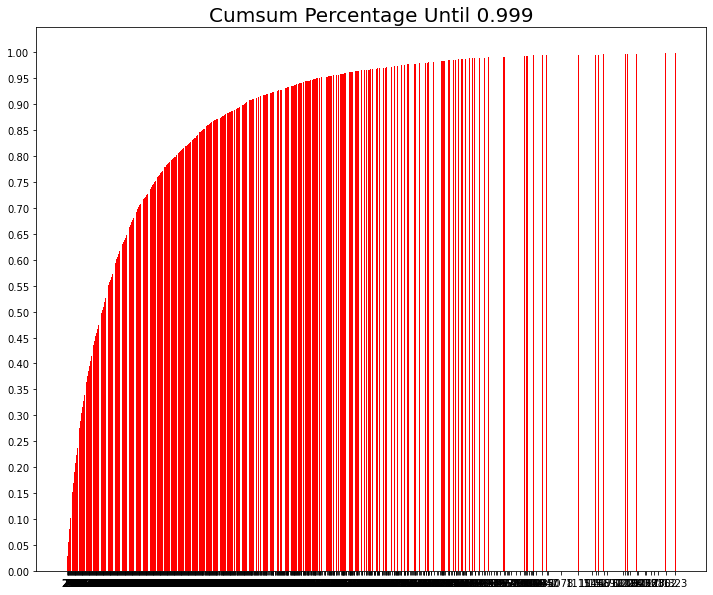

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

__데이터의 시간 관련 정보 확인__
- 추천 시스템을 구축할 때에는 최근 소비 트렌드를 학습하는것이 중요

In [10]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [11]:
type(oldest)

numpy.int64

In [12]:
month_ago = latest - 86400*90    # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,UserId,ItemId,Rating,Time
5200,36,2269,5,1040544350
5256,36,1701,4,1040544350
5184,36,2694,3,1040544494
5364,36,3786,4,1040544521
5262,36,2369,4,1040544564
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [13]:
data['UserId'].nunique(), data['ItemId'].nunique()

(233, 1825)

### Data Cleaning
- 비정상적으로 많이 평가된 아이템뿐만아니라 너무 적게 평가된 아이템도 전처리를 해줘야한다.

__영화별 평가개수 확인__ 

In [14]:
item_popular = data.groupby('ItemId').size()
item_popular

ItemId
1        5
2        3
3        4
5        2
6        5
        ..
3948    16
3949    10
3950     2
3951     1
3952     6
Length: 1825, dtype: int64

In [15]:
min(item_popular), max(item_popular), np.mean(item_popular)

(1, 16, 2.5293150684931507)

In [16]:
item_popular.quantile(0.999)

15.176000000000158

__전처리__
- 19개이하의 평가항목 제외 (사실상 데이터 셋에 존재하지않음)
- 200개이하의 평가가 없는 항목제외

In [17]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_rank) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_rank)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_rank):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_rank].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=19, least_rank=2)
data

,UserId,ItemId,Rating,Time
8704,59,2997,4,1041962568
8781,59,2369,4,1041962664
8797,59,3408,4,1041962692
8808,59,2712,3,1041962692
8809,59,2716,3,1041962731
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [19]:
data['UserId'].nunique(), data['ItemId'].nunique()

(44, 800)

# Step 2. 미니 배치 구성

## Train / Valid / Test

In [20]:
first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
print(first_time, last_time)

2002-12-01 04:17:00 2003-02-28 17:49:50


In [21]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - 86400*n_days].index
    session_in_test = session_last_time[session_last_time >= final_time - 86400*n_days].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [22]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [23]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    first_time = dt.datetime.utcfromtimestamp(data["Time"].min()).strftime('%Y-%m-%d %H:%M:%S')
    last_time = dt.datetime.utcfromtimestamp(data["Time"].max()).strftime('%Y-%m-%d %H:%M:%S')
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {first_time}\n'
          f'\t Last Time : {last_time}\n')

In [24]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 2260
	 Sessions: 39
	 Items: 798
	 First Time : 2002-12-01 04:17:00
	 Last Time : 2003-02-25 19:06:16

* valid Set Stats Info
	 Events: 149
	 Sessions: 3
	 Items: 143
	 First Time : 2002-12-02 18:59:09
	 Last Time : 2003-02-27 13:14:38

* test Set Stats Info
	 Events: 138
	 Sessions: 2
	 Items: 138
	 First Time : 2003-01-09 21:11:55
	 Last Time : 2003-02-28 17:49:50



__인덱싱__

In [25]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

__데이터 저장__

In [26]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Data Pipeline

### SessionDataset

In [27]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

__train에 적용__

In [28]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
8704,59,2997,4,1041962568,0
8781,59,2369,4,1041962664,1
8797,59,3408,4,1041962692,2
8808,59,2712,3,1041962692,3
8809,59,2716,3,1041962731,4
8834,59,2686,4,1041962808,5
8798,59,2396,4,1041962835,6
8839,59,2762,3,1041962835,7
8769,59,3157,3,1041962858,8
8720,59,2070,4,1041962876,9


In [29]:
tr_dataset.click_offsets

array([   0,   83,  163,  209,  232,  324,  351,  538,  603,  646,  675,
        706,  725,  747,  787,  832,  871,  926,  955,  977, 1000, 1028,
       1160, 1192, 1335, 1355, 1376, 1496, 1518, 1573, 1594, 1826, 1873,
       1903, 1933, 1953, 1983, 2025, 2070, 2260], dtype=int32)

In [30]:
tr_dataset.session_idx

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

### SessionDataLoader

In [31]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [32]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
8704,59,2997,4,1041962568,0
8781,59,2369,4,1041962664,1
8797,59,3408,4,1041962692,2
8808,59,2712,3,1041962692,3
8809,59,2716,3,1041962731,4
8834,59,2686,4,1041962808,5
8798,59,2396,4,1041962835,6
8839,59,2762,3,1041962835,7
8769,59,3157,3,1041962858,8
8720,59,2070,4,1041962876,9


In [33]:
iter_ex = iter(tr_data_loader)

In [34]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  83 112 175]
Label Item Idx are :       [  1  84 141 176]
Previous Masked Input Idx are []


# Step 3. 모델 구성

## Evaluation Metric
- Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/구매한 n개의 아이템이 많아야 좋다.
- 따라서 recall의 개념을 확장한 recall@k, precision의 개념을 확장한 Mean Average Precision@k를 사용한다.
- 추천 시스템에서는 몇 번째로 맞추느냐도 중요하다. 따라서 순서의 민감한 지표인 MRR, NDCG같은 지표도 사용한다.

__MRR, recall@k 사용__

In [35]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

## Model Architecture

In [36]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [37]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

__hyper-parameter class화__

In [62]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2, hsz=50, drop_rate=0.1, lr=0.0001, epochs=10, k=20)

In [63]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(2, 1, 798)]             0         
_________________________________________________________________
GRU (GRU)                    [(2, 50), (2, 50)]        127500    
_________________________________________________________________
dropout_5 (Dropout)          (2, 50)                   0         
_________________________________________________________________
dense_5 (Dense)              (2, 798)                  40698     
Total params: 168,198
Trainable params: 168,198
Non-trainable params: 0
_________________________________________________________________


# Step 4. 모델 학습

In [64]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [65]:
# 학습 시간이 다소 오래 소요됩니다. 아래 주석을 풀지 마세요.
train_model(model, args)

Evaluation:  64%|██████▍   | 47/73 [00:02<00:01, 21.46it/s]


	 - Recall@20 epoch 1: 0.000000
	 - MRR@20    epoch 1: 0.000000



Evaluation:  64%|██████▍   | 47/73 [00:01<00:01, 24.87it/s]


	 - Recall@20 epoch 2: 0.021277
	 - MRR@20    epoch 2: 0.001624



Evaluation:  64%|██████▍   | 47/73 [00:01<00:01, 25.50it/s]


	 - Recall@20 epoch 3: 0.031915
	 - MRR@20    epoch 3: 0.003196



Evaluation:  64%|██████▍   | 47/73 [00:01<00:01, 25.50it/s]


	 - Recall@20 epoch 4: 0.042553
	 - MRR@20    epoch 4: 0.004285



Evaluation:  64%|██████▍   | 47/73 [00:01<00:01, 25.08it/s]


	 - Recall@20 epoch 5: 0.031915
	 - MRR@20    epoch 5: 0.004433



Evaluation:  64%|██████▍   | 47/73 [00:01<00:01, 25.13it/s]


	 - Recall@20 epoch 6: 0.031915
	 - MRR@20    epoch 6: 0.004069



Evaluation:  64%|██████▍   | 47/73 [00:02<00:01, 22.74it/s]


	 - Recall@20 epoch 7: 0.031915
	 - MRR@20    epoch 7: 0.004143



Evaluation:  64%|██████▍   | 47/73 [00:01<00:00, 26.12it/s]


	 - Recall@20 epoch 8: 0.031915
	 - MRR@20    epoch 8: 0.004159



Evaluation:  64%|██████▍   | 47/73 [00:01<00:00, 26.22it/s]


	 - Recall@20 epoch 9: 0.031915
	 - MRR@20    epoch 9: 0.003817



Evaluation:  64%|██████▍   | 47/73 [00:01<00:00, 26.23it/s]

	 - Recall@20 epoch 10: 0.031915
	 - MRR@20    epoch 10: 0.004610



# Step 5. 모델 검증

In [66]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  46%|████▌     | 31/68 [00:01<00:01, 26.20it/s]

	 - Recall@20: 0.032258
	 - MRR@20: 0.006336



___
# 프로젝트 정리 


- 결론적으로 안정적인 결과를 얻지 못하였고 아직도 이번 노드에 대해 정확히 이해하지 못하였습니다.